# 001_eda

In [68]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import re

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import texthero as hero
import nltk
from gensim.models import word2vec, KeyedVectors
import cv2

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm


In [2]:
# 試験ID生成
trial_prefix = 'nb001'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb001
nb001_20210516_170414


In [44]:
# アウトプットの出力先指定
OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [6]:
import os
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../00_input/commonlitreadabilityprize/test.csv
../00_input/commonlitreadabilityprize/train.csv
../00_input/commonlitreadabilityprize/sample_submission.csv


In [8]:
DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [9]:
# train/test
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')

# sample_submission
atmacup10__sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# 1. DataCheck

### データを直接眺める

In [10]:
print(train_base.shape)
train_base.head().T

(2834, 6)


,0,1,2,3,4
id,c12129c31,85aa80a4c,b69ac6792,dd1000b26,37c1b32fb
url_legal,NaN,NaN,NaN,NaN,NaN
license,NaN,NaN,NaN,NaN,NaN
excerpt,When the young people returned to the ballroom...,"All through dinner time, Mrs. Fayre was somewh...","As Roger had predicted, the snow departed as q...",And outside before the palace a great garden w...,Once upon a time there were Three Bears who li...
target,-0.340259,-0.315372,-0.580118,-1.05401,0.247197
standard_error,0.464009,0.480805,0.476676,0.450007,0.510845


In [11]:
print(test_base.shape)
test_base.head().T

(7, 4)


,0,1,2,3,4
id,c0f722661,f0953f0a5,0df072751,04caf4e0c,0e63f8bea
url_legal,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Cell_division,https://en.wikipedia.org/wiki/Debugging
license,NaN,NaN,NaN,CC BY-SA 3.0,CC BY-SA 3.0
excerpt,My hope lay in Jack's promise that he would ke...,Dotty continued to go to Mrs. Gray's every nig...,It was a bright and cheerful scene that greete...,Cell division is the process by which a parent...,Debugging is the process of finding and resolv...


In [12]:
print(atmacup10__sample_submission.shape)
atmacup10__sample_submission.head()

(7, 2)


,id,target
0,c0f722661,0.0
1,f0953f0a5,0.0
2,0df072751,0.0
3,04caf4e0c,0.0
4,0e63f8bea,0.0


### ざっくりデータ概要

In [14]:
# dfの概要情報を表示
def df_info(input_df):
    print(f'Shape: {input_df.shape}')
    pd.set_option('display.max_rows', input_df.shape[1])

    df = input_df.dtypes.to_frame()
    df.columns = ['dtypes']
    df['Nunique'] = input_df.nunique()
    df['IsNull'] = input_df.isnull().sum()

    df['Min'] = input_df.min(numeric_only=True)
    df['Median'] = input_df.median(numeric_only=True)
    df['Mean'] = input_df.mean(numeric_only=True)
    df['Max'] = input_df.max(numeric_only=True)
    df['Std'] = input_df.std(numeric_only=True)

    df['top10_val'] = df.index.map(lambda x: input_df[x].value_counts().head(10).index.tolist())
    df['top10_cnt'] = df.index.map(lambda x: input_df[x].value_counts().head(10).values)
    df['top10_ratio'] = df.index.map(
        lambda x: (input_df[x].value_counts().head(10).values / input_df.shape[0]).round(5))

    return df

In [18]:
667/2004

0.3328343313373254

In [15]:
train_info = df_info(train_base)
train_info

Shape: (2834, 6)


,dtypes,Nunique,IsNull,Min,Median,Mean,Max,Std,top10_val,top10_cnt,top10_ratio
id,object,2834,0,NaN,NaN,NaN,NaN,NaN,"[261432a07, 701d0ecf7, 87f96eb79, 20758ef4a, c...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00035, 0.00035, 0.00035, 0.00035, 0.00035, ..."
url_legal,object,667,2004,NaN,NaN,NaN,NaN,NaN,"[https://www.africanstorybook.org/, https://ww...","[118, 46, 2, 1, 1, 1, 1, 1, 1, 1]","[0.04164, 0.01623, 0.00071, 0.00035, 0.00035, ..."
license,object,15,2004,NaN,NaN,NaN,NaN,NaN,"[CC BY 4.0, CC BY-SA 3.0 and GFDL, CC BY-SA 3....","[391, 196, 192, 26, 7, 4, 3, 2, 2, 2]","[0.13797, 0.06916, 0.06775, 0.00917, 0.00247, ..."
excerpt,object,2834,0,NaN,NaN,NaN,NaN,NaN,"[When the Little Colonel reached the hotel, th...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00035, 0.00035, 0.00035, 0.00035, 0.00035, ..."
target,float64,2834,0,-3.676268,-0.912190,-0.959319,1.711390,1.033579,"[-1.628925901, -1.340719333, -1.561415394, -1....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00035, 0.00035, 0.00035, 0.00035, 0.00035, ..."
standard_error,float64,2834,0,0.000000,0.484721,0.491435,0.649671,0.034818,"[0.5098285770000001, 0.456097739, 0.6140356889...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.00035, 0.00035, 0.00035, 0.00035, 0.00035, ..."


In [17]:
test_info = df_info(test_base)
test_info

Shape: (7, 4)


,dtypes,Nunique,IsNull,Min,Median,Mean,Max,Std,top10_val,top10_cnt,top10_ratio
id,object,7,0,NaN,NaN,NaN,NaN,NaN,"[0e63f8bea, 04caf4e0c, 965e592c0, c0f722661, f...","[1, 1, 1, 1, 1, 1, 1]","[0.14286, 0.14286, 0.14286, 0.14286, 0.14286, ..."
url_legal,object,3,4,NaN,NaN,NaN,NaN,NaN,"[https://www.africanstorybook.org/#, https://e...","[1, 1, 1]","[0.14286, 0.14286, 0.14286]"
license,object,2,4,NaN,NaN,NaN,NaN,NaN,"[CC BY-SA 3.0, CC BY 4.0]","[2, 1]","[0.28571, 0.14286]"
excerpt,object,7,0,NaN,NaN,NaN,NaN,NaN,[My hope lay in Jack's promise that he would k...,"[1, 1, 1, 1, 1, 1, 1]","[0.14286, 0.14286, 0.14286, 0.14286, 0.14286, ..."


## 分布確認_target

In [23]:
def show_numeric_hist(_df:pd.DataFrame(), colname:str, bins=100):
    _df[colname].fillna(-1).hist(bins=bins)
    plt.title(colname)
    plt.show()

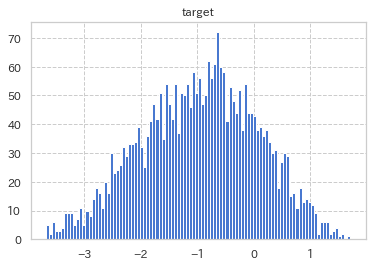

In [25]:
show_numeric_hist(train_base, 'target')

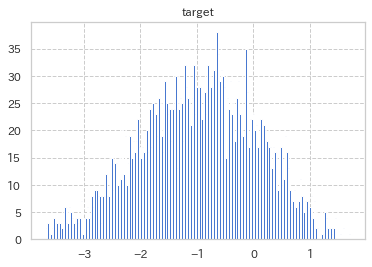

In [34]:
show_numeric_hist(train_base, 'target', bins=200)

## targetの高低と各カラムの中身（ざっと眺める）

In [47]:
under = train_base[train_base['target'] < -3.5]['excerpt']
under.to_csv(OUTPUT_DIR/'excerpt_with_target_u-3.5.csv')
under

493     Molecular nanotechnology (MNT) is a technology...
1128    The Dunwich horror itself came between Lammas ...
                              ...                        
1839    The copper even of such a conductor has been m...
2770    For staining Bacillus tuberculosis the followi...
Name: excerpt, Length: 13, dtype: object

In [52]:
upper = train_base[train_base['target'] > 1.3]['excerpt']
upper.to_csv(OUTPUT_DIR/'excerpt_with_target_o1.3.csv')
upper

240     There was once a young man who spent all his t...
564     After a night of heavy rain, a group of friend...
                              ...                        
2602    One day her mother said to her: "Come, Red Rid...
2829    When you think of dinosaurs and where they liv...
Name: excerpt, Length: 15, dtype: object

## excerptの加工
- テキストの長さ
- 単語数
- 単語の種類数

In [58]:
import nltk

In [59]:
nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['dutch',
 'german',
 'slovene',
 'hungarian',
 'romanian',
 'kazakh',
 'turkish',
 'russian',
 'README',
 'italian',
 'english',
 'greek',
 'tajik',
 'norwegian',
 'portuguese',
 'finnish',
 'danish',
 'french',
 'swedish',
 'azerbaijani',
 'spanish',
 'indonesian',
 'arabic',
 'nepali']

In [62]:
# 単語数
# テキスト前処理
def text_normalization(text):

    # nltkベースのstopword指定
    custom_stopwords = nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

In [81]:
txt = text_normalization(train_base['excerpt'])[0]

In [85]:
txt_list = [wrd for wrd in txt.split(" ") if wrd not in ('', '\n')]
txt_list

['young',
 'people',
 'returned',
 'ballroom',
 'presented',
 'decidedly',
 'changed',
 'appearance',
 'instead',
 'interior',
 'scene',
 'winter',
 'landscape',
 'floor',
 'covered',
 'snow',
 'white',
 'canvas',
 'laid',
 'smoothly',
 'rumpled',
 'bumps',
 'hillocks',
 'like',
 'real',
 'snow',
 'field',
 'numerous',
 'palms',
 'evergreens',
 'decorated',
 'room',
 'powdered',
 'flour',
 'strewn',
 'tufts',
 'cotton',
 'like',
 'snow',
 'also',
 'diamond',
 'dust',
 'lightly',
 'sprinkled',
 'glittering',
 'crystal',
 'icicles',
 'hung',
 'branches',
 'end',
 'room',
 'wall',
 'hung',
 'beautiful',
 'bear',
 'skin',
 'rug',
 'rugs',
 'prizes',
 'one',
 'girls',
 'one',
 'boys',
 'game',
 'girls',
 'gathered',
 'one',
 'end',
 'room',
 'boys',
 'one',
 'end',
 'called',
 'north',
 'pole',
 'south',
 'pole',
 'player',
 'given',
 'small',
 'flag',
 'plant',
 'reaching',
 'pole',
 'would',
 'easy',
 'matter',
 'traveller',
 'obliged',
 'wear',
 'snowshoes']

In [88]:
# 単語数
len(txt_list)

91

In [89]:
import collections

In [90]:
c = collections.Counter(txt_list)

In [93]:
# 単語のユニーク数(種類数)
len(c)

76

In [107]:
# 単語数(counterから取得)
sum(c.values())

91

In [103]:
# 単語の出現回数の平均
np.mean(list(c.values()))

1.1973684210526316

In [ ]:
pd.DataFrame(pd.Series(arr.ravel()).describe()).transpose()

In [201]:
# 単語自体の長さに関する統計量
# 参考: https://qiita.com/AnchorBlues/items/051dc69e81705b52adad
word_length = np.array([len(i) for i in c.keys()])
pd.Series(word_length.ravel()).describe()

count    76.000000
mean      6.052632
           ...    
75%       8.000000
max      10.000000
Length: 8, dtype: float64

In [143]:
# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

In [202]:
txt = text_normalization(train_base['excerpt'])

In [203]:
counters = txt.map(get_counter)

In [232]:
word_length = counters.map(lambda x: np.array([len(i) for i in x.keys()]))
word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
tmp_word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]

In [233]:
tmp_word_length_desc_df.head()

,mean,std,min,25%,50%,75%,max
0,6.052632,1.945215,3.0,4.0,6.0,8.0,10.0
1,5.666667,2.168923,2.0,4.0,5.0,7.0,11.0
...,...,...,...,...,...,...,...
3,5.345238,1.682612,3.0,4.0,5.0,6.0,12.0
4,4.695652,1.395929,3.0,4.0,5.0,5.0,8.0


In [144]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

In [237]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

In [238]:
block = TextDescriptionBlock('excerpt')
tst = block.fit(train_base)

In [239]:
tst

,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,word_length_75%_excerpt,word_length_max_excerpt
0,992,91,76,1.197368,4,6.052632,1.945215,3.0,4.0,6.0,8.0,10.0
1,937,85,72,1.180556,4,5.666667,2.168923,2.0,4.0,5.0,7.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2832,864,81,64,1.265625,5,5.609375,2.164777,1.0,4.0,5.0,7.0,12.0
2833,885,78,61,1.278689,4,5.885246,2.176376,2.0,4.0,6.0,7.0,13.0


In [240]:
block = TextDescriptionBlock('excerpt')
assert len(train_base) == len(block.fit(train_base))

### 単語に関する統計量_分布確認

In [246]:
block = TextDescriptionBlock('excerpt')
excerpt_df = block.fit(train_base)
train = pd.concat([train_base, excerpt_df], axis=1)

In [247]:
excerpt_df.columns

Index(['text_length_excerpt', 'word_count_excerpt', 'word_nunique_excerpt',
       'word_appearance_mean_excerpt', 'word_appearance_max_excerpt',
       'word_length_mean_excerpt', 'word_length_std_excerpt',
       'word_length_min_excerpt', 'word_length_25%_excerpt',
       'word_length_50%_excerpt', 'word_length_75%_excerpt',
       'word_length_max_excerpt'],
      dtype='object')

In [248]:
word_cols = excerpt_df.columns.tolist()

In [249]:
train_tmp = train[['target'] + word_cols]
train_tmp.head()

,target,text_length_excerpt,word_count_excerpt,word_nunique_excerpt,word_appearance_mean_excerpt,word_appearance_max_excerpt,word_length_mean_excerpt,word_length_std_excerpt,word_length_min_excerpt,word_length_25%_excerpt,word_length_50%_excerpt,word_length_75%_excerpt,word_length_max_excerpt
0,-0.340259,992,91,76,1.197368,4,6.052632,1.945215,3.0,4.0,6.0,8.0,10.0
1,-0.315372,937,85,72,1.180556,4,5.666667,2.168923,2.0,4.0,5.0,7.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-1.054013,909,94,84,1.119048,2,5.345238,1.682612,3.0,4.0,5.0,6.0,12.0
4,0.247197,723,74,23,3.217391,12,4.695652,1.395929,3.0,4.0,5.0,5.0,8.0


### 単語に関する統計量_単純な分布確認

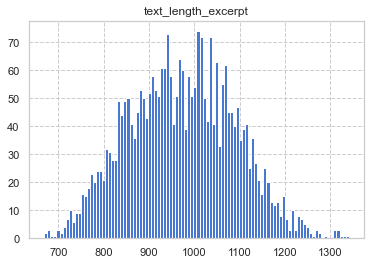

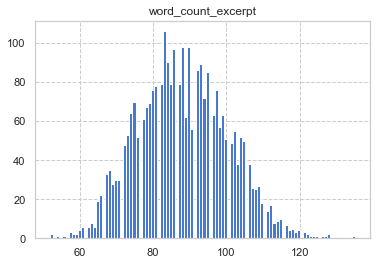

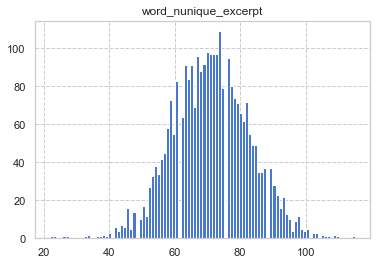

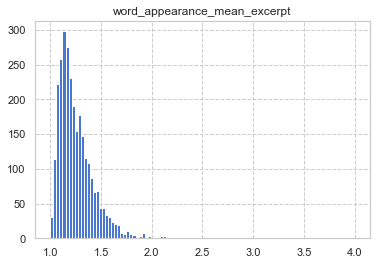

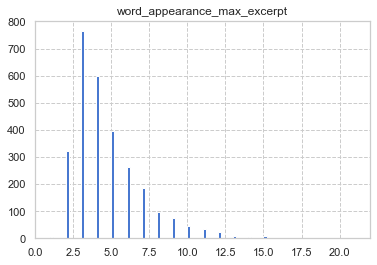

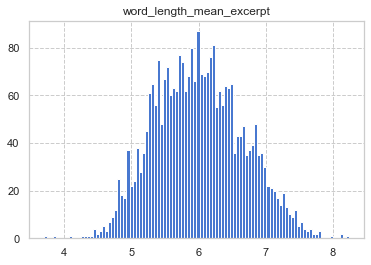

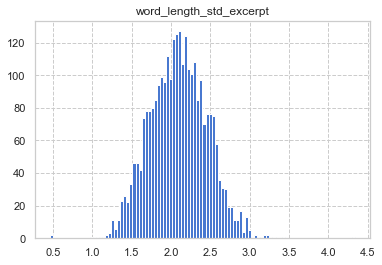

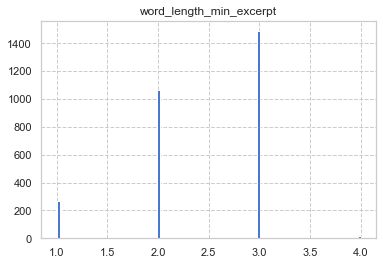

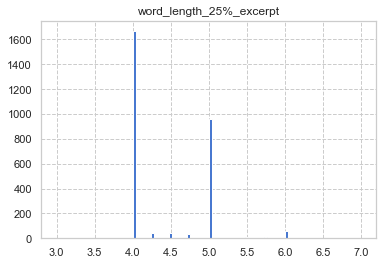

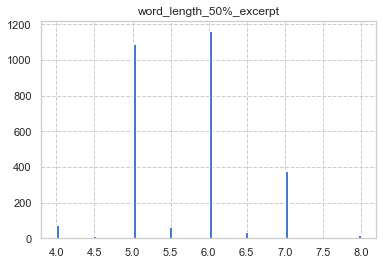

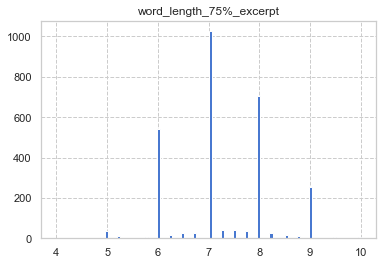

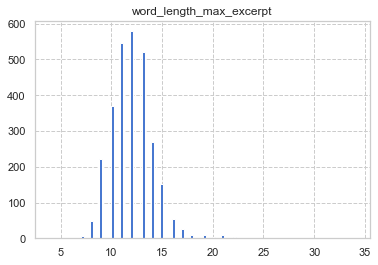

In [250]:
for col_ in word_cols:
    show_numeric_hist(train_tmp, col_)

### 単語に関する統計量_targetとの相関確認

<AxesSubplot:>

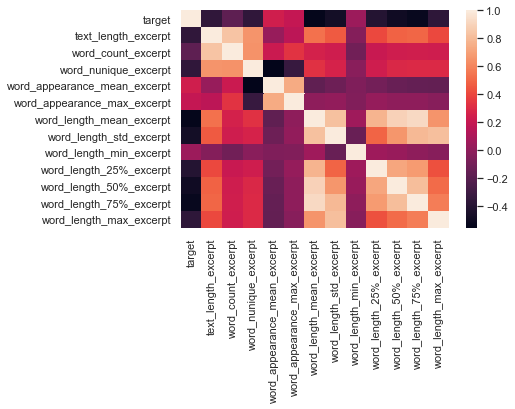

In [251]:
# 相関係数のヒートマップ
sns.heatmap(train_tmp.corr())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


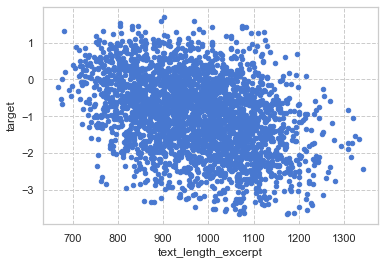

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


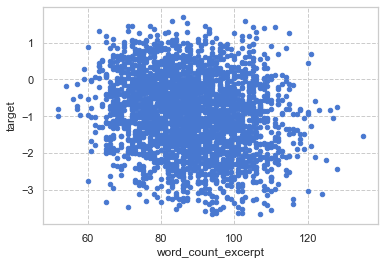

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


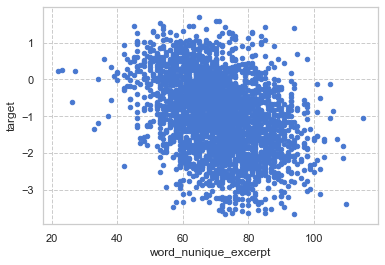

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


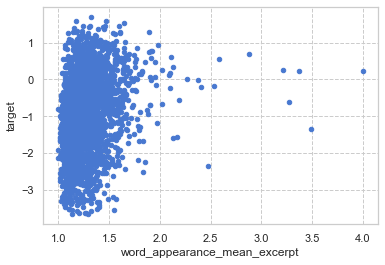

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


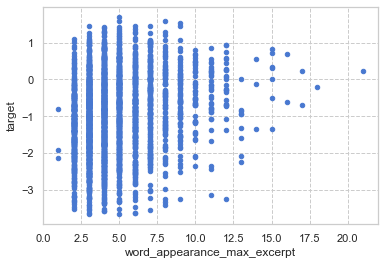

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


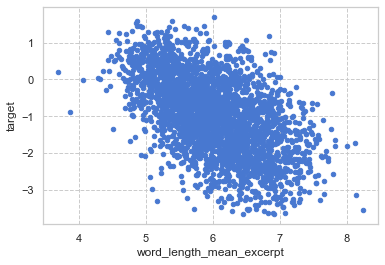

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


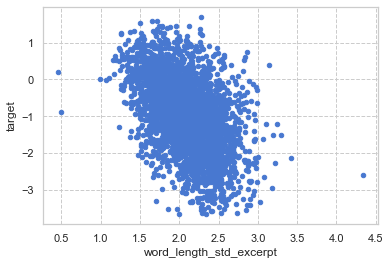

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


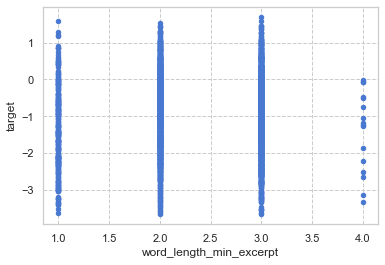

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


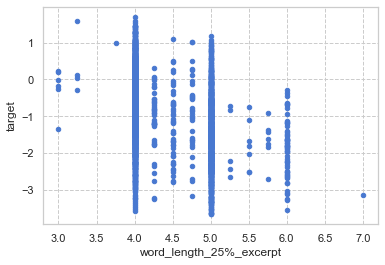

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


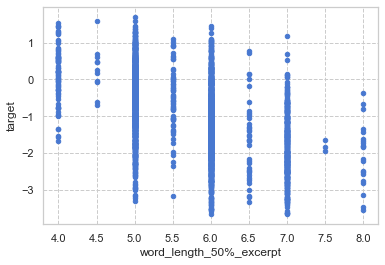

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


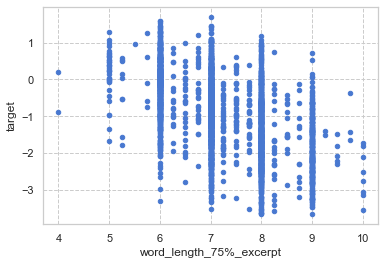

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


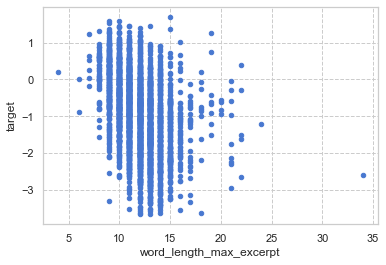

In [258]:
# 特徴×targetの散布図
for col_ in word_cols:
    train_tmp.plot(kind='scatter', x=col_, y='target')
    plt.show()

# train & predict
- 各特徴が効いてそうかだけ確認する。

In [267]:
train_feat = train_tmp.drop('target', axis=1).copy()
train_target = train_tmp['target'].copy()

In [268]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [269]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [270]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [271]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [273]:
# testの前処理は一時的に除外
oof_preds = np.zeros(len(train_feat))
#test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train[target].iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train[target].iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    #test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train[target], oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1235
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 12
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's rmse: 0.696437	valid's rmse: 0.800067

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 12
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's rmse: 0.709531	valid's rmse: 0.8

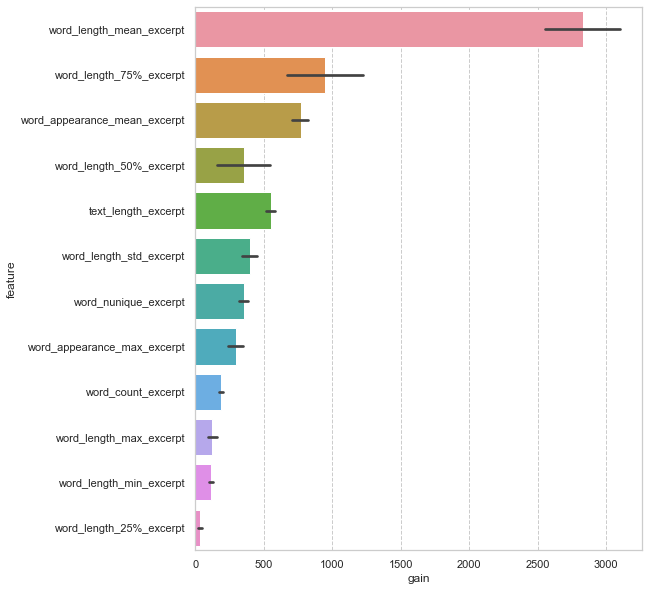

In [274]:
plt.figure(figsize=(8, 10))
sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

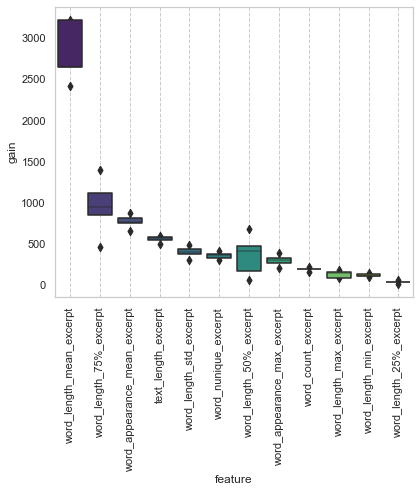

In [275]:
# CVごとのブレをboxen plotとして表現
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/
order = importances.groupby('feature')\
    .sum()[['gain']]\
    .sort_values('gain', ascending=False).index[:50]

fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
ax.tick_params(axis='x', rotation=90)
ax.grid()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [277]:
# SHAPによる可視化。
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

shap_values = []
for model_ in models:
    explainer = shap.TreeExplainer(model_)
    shap_values.append(explainer.shap_values(train_feat))
    
shap_mean = np.mean(shap_values, axis=0)

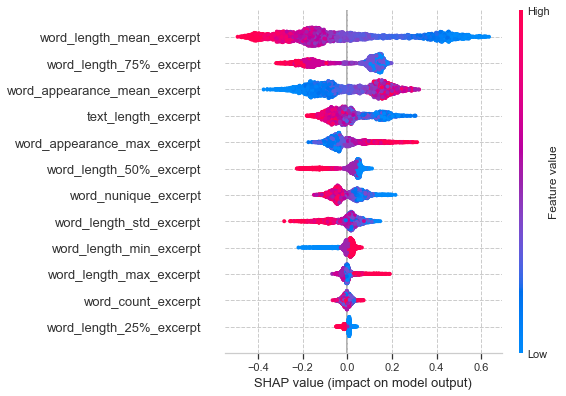

In [279]:
# summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
shap.summary_plot(shap_mean, train_feat, show=False)
plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

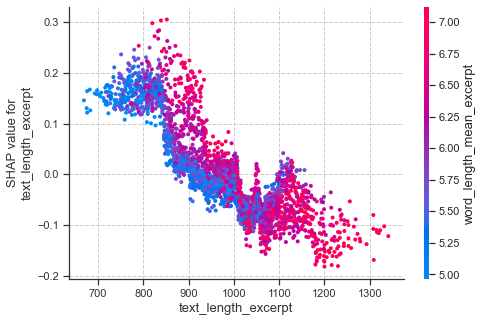

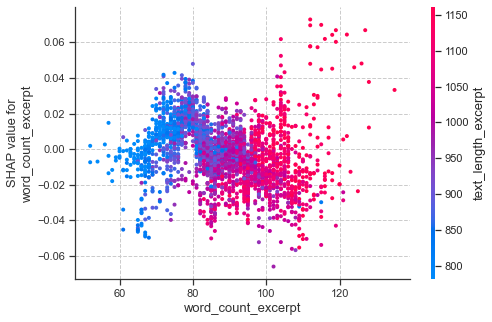

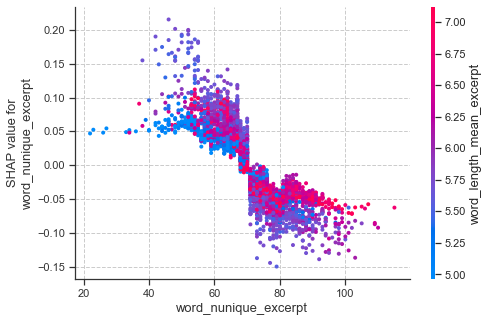

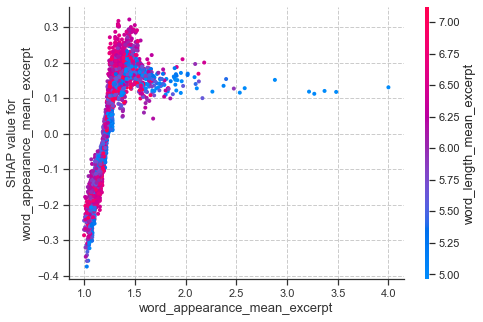

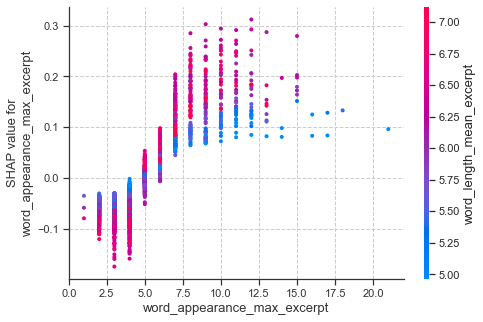

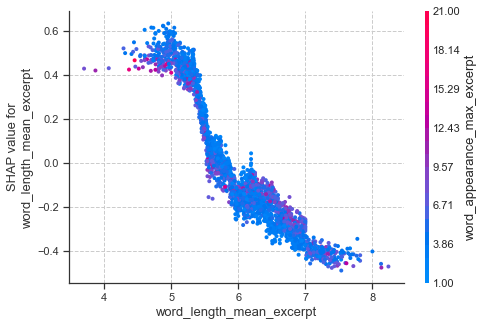

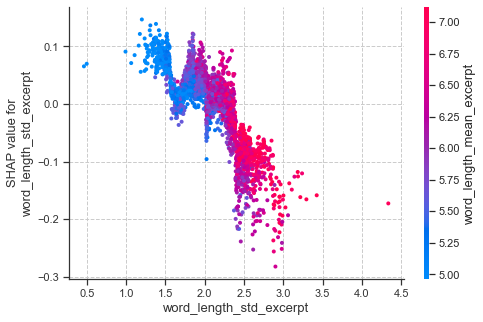

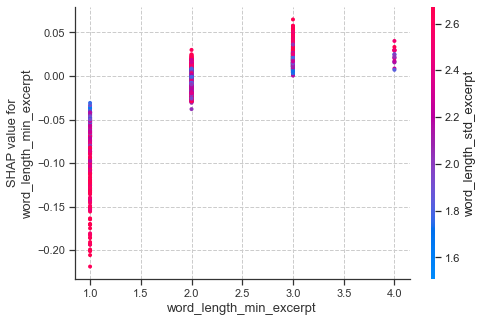

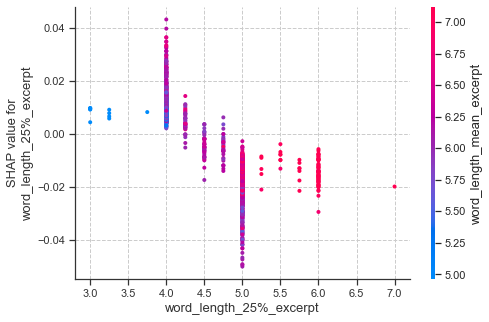

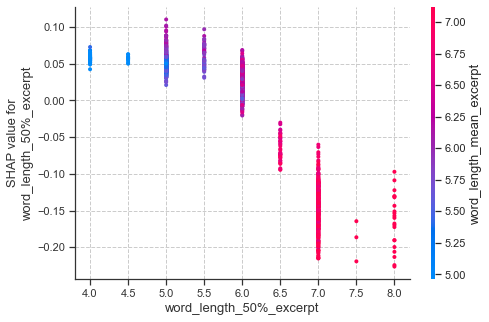

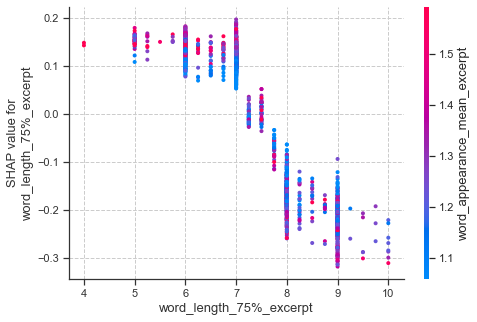

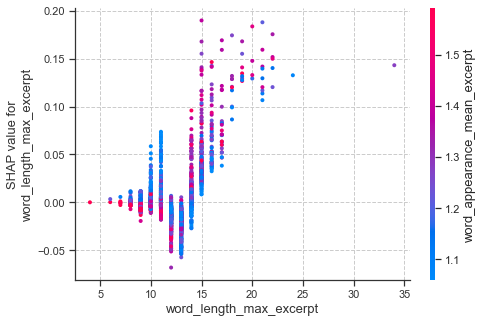

In [284]:
for col_ in train_feat.columns:
    shap.dependence_plot(col_, shap_mean, train_feat)

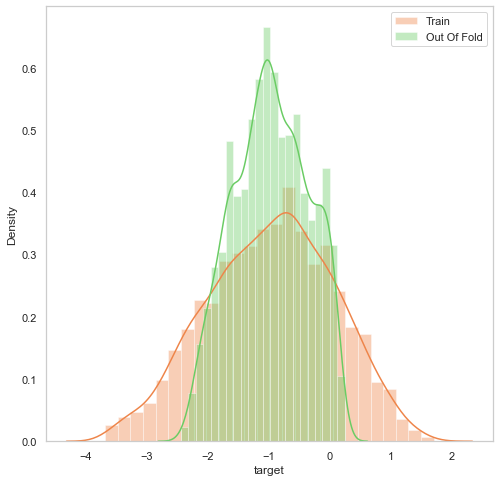

In [285]:
# 分布(train_vs_oof)
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(train_target, label='Train', ax=ax, color='C1')
sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
ax.legend()
ax.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))

## お試し: 線形回帰 

In [288]:
from sklearn.linear_model import LinearRegression

In [296]:
# testの前処理は一時的に除外
oof_preds = np.zeros(len(train_feat))
#test_preds = np.zeros(len(test_feat))

scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train[target].iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train[target].iloc[valid_index]
    
    model = LinearRegression()
    model.fit(
        X=trn_x,
        y=trn_y
    )

    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    #test_preds += model.predict(test_feat) / 5
    
    val_score = np.sqrt(mean_squared_error(val_y, val_preds))
    scores.append(val_score)
    models.append(model)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train[target], oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5
Mean RMSE: 0.819648528443159, std: 0.014014473316518571, All RMSE: 0.8197778972909456


## お試し: SVM 

In [297]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [301]:
# testの前処理は一時的に除外
oof_preds = np.zeros(len(train_feat))
#test_preds = np.zeros(len(test_feat))

scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train[target].iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train[target].iloc[valid_index]
    
    model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    model.fit(
        X=trn_x,
        y=trn_y
    )

    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    #test_preds += model.predict(test_feat) / 5
    
    val_score = np.sqrt(mean_squared_error(val_y, val_preds))
    scores.append(val_score)
    models.append(model)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train[target], oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5
Mean RMSE: 0.8220821400913894, std: 0.015858571149314146, All RMSE: 0.8222433835450885
